# Mininal discrete matching algorithm doubts
I'm having some doubts about my minimal discrete matching algorithm.
I've been normalizing the size and mass ratios by the larges particle size, but I'm questioning that approach.
Originally, I had been building a matrix that compared every entry against every other entry, but I abandoned that for a vector that only compares to the largest size.
Additionally, I've assumed that the minimal discrete match will always correspond to the largest size being as small as it's allowed by the target GSD.
Now I am trying to convince myself whether I can truly have claim to have found the minimal discrete match if I haven't thoroughly examined all possibilities for the largest size.

# Testing plan
In order to test the limits of my approach, I'm going to look at several instances of mass distribution and particle size distribution for a discrete matching set with four distinct sizes.
I will attempt to create vectors (or matrices?) of "percent mass per particle" for a unit size set (where $q_i = 1$).
Then the target GSD percent mass divided by these vectors should produce the required number of particles.
I want to minimize the total number *and* find a spanned integer between instances where I've assumed the largest and the smallest possible particle sizes. 

One problem is that if I'm not holding any given size constant, the percent mass per particle will not be constant either.

## Critical size?
The percent mass per particle thing didn't pan out. 
At the end of the day, there still needs to be a specific particle size that's the focus.
But what if that's not the largest?

## Modify existing library
I haven't been able to find a better algorithm, but I'm still not at ease about my solution finding the true minimum in all possible cases. 
My next approach will be to modify my existing library to change which element it uses as the baseline (currently uses the largest).
Then I can explore whether the solution diverges if I change that parameter.

### Convergence problem
At first, this seemed to be working. 
And there were cases where using the smallest size as the baseline seemed to give better answers (lower number of total particles).
But it was taking forever and I didn't know why.
Then I looked at the errors and they had not converged, simply timed out and returned their latest values!



In [1]:
import numpy as np
from gsd_lib import GSD, MinimalPackingGenerator
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib widget


In [21]:
# Define the sizes in G
x_g = np.array([1.11, 1.12, 1.13, 1.14, 1.15]) # Closely spaced values

x_g = np.array(
    [
        0.0001,  # Pan
        0.075,  # Number 200 sieve separates coarse from fines
        0.15,
        0.3,
        0.6,
        1.18,
        2.36,
        4.75,  # Number 4 sieve separates sand from gravel
        9.5,
        19,
        25,
        37.5,
        50,
        63,
        75,  # 3-inch sieve (100% passing this per ASTM D2487-17 1.2)
    ]
)
# x_g = np.array([1.11, 2.11, 3.11, 4.11, 5.11])  # Integer-spaced values

# Define the masses in G (final mass will always be zero since the size matches will have length len(G)-1)
m_g = np.linspace(0.001, 1.0, num=len(x_g)) # even distribution
# m_g = np.array([1.0, 2.0, 4.0, 8.0, 0])  # top-heavy distribution
# m_g = np.array([8.0, 4.0, 2.0, 1.0, 0])  # bottom-heavy distribution
m_g[-1] = 0  # Ensure the last mass is zero

g = GSD(sizes=x_g, masses=m_g)

# mdm = MinimalPackingGenerator(
#     gsd=g, x_n_factor=0.5, tol=1e-3, flex=True, density=1.0, ref_pos=0.5
# )

# # Calculate the minimum and maximum sizes for S
# x_s_min = np.nextafter(x_g[:, :-1], x_g[:, :-1] + 1) # next representable float greater than each element in x_g[:-1]
# x_s_max = x_g[:, 1:]

# # Calculate the volume of each size in S
# v_s_min = x_s_min**3
# v_s_max = x_s_max**3

# # Calculate the masses in S
# m_s = m_g[:,:-1]

In [22]:
zp = np.nextafter(0, 1)  # smallest positive float
om = np.nextafter(1, 0)  # largest float less than 1
xns = np.linspace(zp, om, 10)  # x_n values from smallest positive float to largest float less than 1
rps = np.linspace(zp, om, len(g.sizes) - 1)  # ref_pos values from smallest positive float to largest float less than 1

rp_list = []
xn_list = []
n_list = []
min_n = 10000000
for rp in rps:
    for x_n in xns:
        mdm = MinimalPackingGenerator(
            gsd=g, x_n_factor=x_n, tol=1e-3, flex=True, density=1.0, ref_pos=rp
        )
        n = sum(mdm.mps.quantities)
        if True:#n < min_n:
            min_n = n
            rp_list.append(rp)
            xn_list.append(x_n)
            n_list.append(sum(mdm.mps.quantities))

In [23]:
d = {
    "size": rp_list,
    "skew": xn_list,
    "n": n_list
}

df = pd.DataFrame(d)

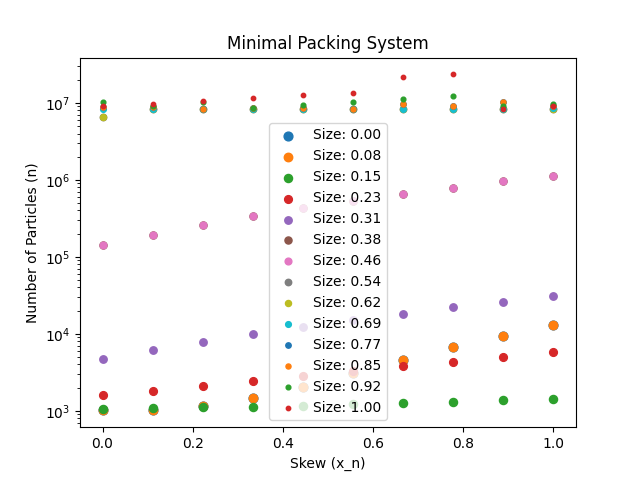

In [24]:
fig, ax = plt.subplots()

for group, data in df.groupby('size'):
    if group > 0.0:
        ax.scatter(data['skew'], data['n'], s=(2-group)**2 * 10, label=f'Size: {group:.2f}')

ax.set_yscale('log')
ax.set_xlabel('Skew (x_n)')
ax.set_ylabel('Number of Particles (n)')
ax.set_title('Minimal Packing System')
ax.legend()
plt.show()

In [9]:
mdm.phi

array([0.1147541 , 0.18852459, 0.26229508, 0.33606557, 0.40983607,
       0.48360656, 0.55737705, 0.63114754, 0.70491803, 0.77868852,
       0.85245902, 0.92622951, 1.        , 1.07377049])